# HPC Stage One

# OpenCL Implementation

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import LinearOperator, gmres, bicgstab
from functools import partial
import pyopencl as cl
import inspect

# Create some context
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [2]:
def poisson_operator(U, sigma, Nx, Ny):
    """
    Applies the given operator from the coursework description onto a vector U. 
    
    Inputs: 
    - Nx:           The number of gridpoints in x space
    - Ny:           The number of gridpoints in the y space
    - sigma:        A known field function in the x, y space
    - U:            A 1D vector of length Nx*Ny representing the x,y space.
                    The components of U have been stack horizontally. i.e., 
                    U[i] represents co-ordinate ( (i%Nx)*dx, int(i/Nx)*dy )
                    where, dx, dy are the grid spacings in x and y
    """
    
    kernel = """
    
    __kernel void poissonOperator(__global double *U,
                                  __global double *result,
                                  __global double *sigma,
                                  const int Nx,
                                  const int Ny){
    
        int gid = get_global_id(0);
        
        double dx = 1.0/Nx;
        double dy = 1.0/Ny;
        
        
        if(gid < Nx || gid > Nx*(Ny-1) - 1 || gid%Nx == 0 || (gid+1)%Nx == 0){
            result[gid] = 0.0;
        }
        else{
            result[gid] = - 1/(2*dx*dx)
                      * ( (sigma[gid+1] + sigma[gid]) * (U[gid+1] - U[gid])
                        - (sigma[gid-1] + sigma[gid]) * (U[gid] - U[gid-1]) )
                      - 1/(2*dy*dy) 
                      * ( (sigma[gid+Nx] + sigma[gid]) * (U[gid+Nx] - U[gid])
                        - (sigma[gid-Nx] + sigma[gid]) * (U[gid] - U[gid-Nx]) );
             } 
    }
    
    """
    
    
    mf = cl.mem_flags
    
    work_items = int(len(U))
       
    U_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=U)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR | mf.WRITE_ONLY, size=len(U) * 8)
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    kernel_args = (U_buffer, result_buffer, sigma_buffer, np.int32(Nx), np.int32(Ny))
    
    prg = cl.Program(ctx, kernel)
    prg.build()
    potential_kernel = prg.poissonOperator
    
    potential_kernel(queue, (work_items, ), (1, ), *kernel_args) 

    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                  0, (work_items, ), np.double)
    
    result = np.resize(result, (Nx,Ny))
    
    return result

In [3]:
def get_residuals(u_k, residuals):
    """
    Used for 'callback' argument for gmres and bicgstab
    solutions when recording convergence.
    
    Records residual of the currentsolution vector, 'u_k', 
    and appends to input list 'residuals'
    """
    frame = inspect.currentframe().f_back
    residuals.append(frame.f_locals['resid'])

### OpenCL/SciPy Solutions for $\sigma(x, y) = e^{-S(x, y)}$ 

In [4]:
###########################################
# Iniating problem
###########################################

Nx = 100
Ny = 100
U = np.zeros(Nx*Ny)

normal_dist = np.random.normal(0, 0.1, (Nx+1)*(Ny+1)) # variance of 0.1 because higher var requires higher iterations to solve
sigma = np.exp(normal_dist)
f = np.ones(Nx*Ny)

# Forcing boundary conditions on f
for i in range(Nx*Ny):
    if i < Nx or i > Nx*(Ny-1) - 1 or i%Nx == 0 or (i+1)%Nx == 0:
        f[i]=0

poissonOp = LinearOperator((Nx*Ny,Nx*Ny), matvec=partial(poisson_operator, sigma=sigma, Nx=Nx, Ny=Ny))

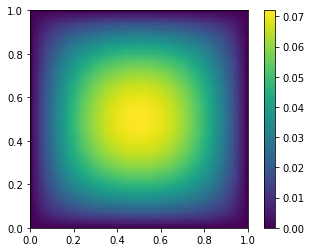

In [5]:
########################################
# Solving using gmres
########################################

gmres_res = []
u_soln_gmres, _ = gmres(poissonOp, f,
                        callback = partial(get_residuals, residuals=gmres_res))

u_soln_gmres = np.resize(u_soln_gmres, (Ny, Nx))

plt.imshow(u_soln_gmres, extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()

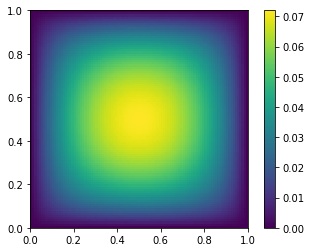

In [6]:
#############################################
# Solving using bicgstab
#############################################

bicgstab_res = [] # stores residuals 
u_soln_bicgstab, _ = bicgstab(poissonOp, f, 
                              callback = partial(get_residuals, residuals=bicgstab_res))
u_soln_bicgstab = np.resize(u_soln_bicgstab, (Ny,Nx))

plt.imshow(u_soln_bicgstab, extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()

### Convergence of Iterative Solvers for $\sigma(x, y) = e^{-S(x, y)}$ 
compares the convergence of the two iterative methods by plotting the residual of solution at each iteration vs number of iterations

Text(0, 0.5, 'log(Residual)')

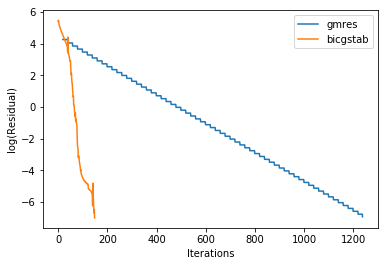

In [7]:
plt.plot(np.log(gmres_res), label = 'gmres')
plt.plot(np.log(bicgstab_res), label = 'bicgstab')
grad_gmres = (np.log(gmres_res)[-1]-np.log(gmres_res)[0])/(len(gmres_res)-0)
grad_bicgstab = (np.log(bicgstab_res)[-1]-np.log(bicgstab_res)[0])/len(bicgstab_res)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('log(Residual)')

# Comparing OpenCL and FeniCS Solutions for $\sigma(x, y) = 1 + x^2 + y^2$ 
## OpenCL/Scipy Solutions:

In [8]:
######################################
# Initialising Problem
######################################

Nx = 100
Ny = 100
U = np.zeros(Nx*Ny)

x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)

xx, yy = np.meshgrid(x, y)
sigma = 1+xx**2+yy**2

sigma = np.hstack(sigma)

f = np.ones(Nx*Ny)
# Forcing BCs on f
for i in range(Nx*Ny):
    if i < Nx or i > Nx*(Ny-1) - 1 or i%Nx == 0 or (i+1)%Nx == 0:
        f[i]=0

poissonOp = LinearOperator((Nx*Ny,Nx*Ny), matvec=partial(poisson_operator, sigma=sigma, Nx=Nx, Ny=Ny))        

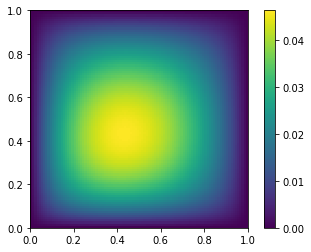

<Figure size 432x288 with 0 Axes>

In [9]:
#######################################
# Solve using gmres
#######################################

u_soln_gmres, _ = gmres(poissonOp, f)
np.save("u_soln_gmres", u_soln_gmres) # save data to file 
u_soln_gmres = np.resize(u_soln_gmres, (Ny,Nx))
u_soln_gmres = np.flipud(u_soln_gmres) # flipping output to be correct orientation (unnecessary for previous symmetric solution)

plt.imshow(u_soln_gmres, extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()
plt.savefig("gmres_plot.png")

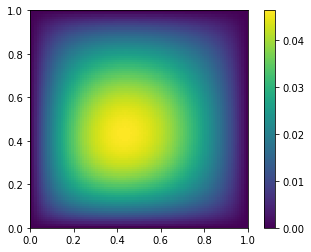

<Figure size 432x288 with 0 Axes>

In [10]:
##########################################
# Solving using bicgstab
##########################################

u_soln_bicgstab, _ = bicgstab(poissonOp, f)
np.save("u_soln_bicgstab", u_soln_gmres) # save data to file
u_soln_bicgstab = np.resize(u_soln_bicgstab, (Ny,Nx))
u_soln_bicgstab = np.flipud(u_soln_bicgstab) # rotating output to be correct orientation

plt.imshow(u_soln_bicgstab, extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()
plt.savefig("gbicgstab_plot.png")

## Fenics Solution

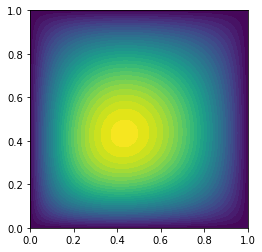

In [1]:
%matplotlib inline 
from fenics import *
import numpy as np
import matplotlib as plt

# Create mesh and define function space
mesh = UnitSquareMesh(100, 100)
V = FunctionSpace(mesh, 'Lagrange', 1)

# Define boundary condition
u_D = Constant(0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)
sigma = Expression("1+x[0]*x[0]+x[1]*x[1]", element=V.ufl_element())

# Define variational problem
u = Function(V)  
v = TestFunction(V)
f = Constant(1)
F =  - dot(sigma*grad(u), grad(v))*dx + f*v*dx 

# Compute solution
solve(F == 0, u, bc)

# Plot solution
plot(u)